In [1]:
import torch
from torch import optim
from torch import nn

import pandas as pd
import numpy as np

from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import PIL
import random
import os

import torch.nn.functional as F

random.seed(321)

The first trial that involves Siamese Networks and Contrastive Loss Function.

For this task, we have a set of celebrity images that we want to train a machine learning model on. We want to it to recognize when 2 pictures belong to the same person or not, so that later we can give it any 2 pictures of a random person and it will predict if they do, in fact, belong to the same person or if they are completely different people.

This is how we would normally load in images using pytorch:

Note that we are using pytorch to resize to 255 pixels and center on 224 pixels. This insures all our images are the same size and in sqaure shape.

In [2]:
data_dir = 'facial_recognition_data'

transform = transforms.Compose([transforms.Resize(255),
                               transforms.CenterCrop(224),
                               transforms.ToTensor()])

dataset = datasets.ImageFolder(data_dir, transform = transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

Taking a look at an image:

In [3]:
def show_image(image):
    image = image.numpy().transpose((1, 2, 0))
    plt.imshow(image, cmap='gray')
    plt.xticks([])
    plt.yticks([])

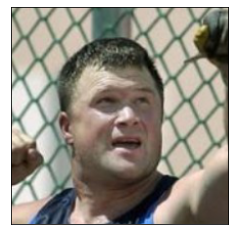

In [804]:
images, labels = next(iter(dataloader))
show_image(images[0])

We have 1680 image folders for each celebrity (each folder containing at least 2 pictures of that celebrity). We will be splitting them into 3 bigger folders for train, validation and test sets. We will take 20% of all the data as test_data and the remaining as train_data. Then, 20% of the train_data will be taken as val_data (validation).

See the below image:

![folders](notebook_images/facefolders.JPG)

Now, if we leave things as they are, pytorch will try to classify each celebrity on its own. So, for 1680 celebrities, we would be having an output of 1680 classes. This is not what we want to do. We want our output to be binary in the form of 0 if two incoming pictures belong to the same person or 1 if not.

Therefore, we will need to create a few of our own custom functions.

In [4]:
train_folder = datasets.ImageFolder(os.path.join(data_dir, 'train_data'))
test_folder = datasets.ImageFolder(os.path.join(data_dir, 'test_data'))
val_folder = datasets.ImageFolder(os.path.join(data_dir, 'val_data'))

In [5]:
type(train_folder)

torchvision.datasets.folder.ImageFolder

In [6]:
train_folder.imgs[:5]

[('facial_recognition_data\\train_data\\Aaron_Peirsol\\Aaron_Peirsol_0001.jpg',
  0),
 ('facial_recognition_data\\train_data\\Aaron_Peirsol\\Aaron_Peirsol_0002.jpg',
  0),
 ('facial_recognition_data\\train_data\\Aaron_Peirsol\\Aaron_Peirsol_0003.jpg',
  0),
 ('facial_recognition_data\\train_data\\Aaron_Peirsol\\Aaron_Peirsol_0004.jpg',
  0),
 ('facial_recognition_data\\train_data\\Aaron_Sorkin\\Aaron_Sorkin_0001.jpg',
  1)]

In [7]:
def Noahs_df(imgs):
    '''
    Takes only a pair of images from each folder and returns a dataframe
    
    Args:
        imgs: list of tuples containing paths of images and their folder number
        
    Returns:
        Dataframe containing path and folder columns for each image
    '''
    df_constructor = {'path':[], 'folder':[]}
    for path, folder in imgs:
        if df_constructor['folder'].count(folder) == 2:
            continue
        df_constructor['path'].append(path)
        df_constructor['folder'].append(folder)    

    return pd.DataFrame(df_constructor)

In [8]:
class NoahsDataset(Dataset):
    '''
    Prepares data to be given to pytorch's DataLoader. 
    Essentially, a pair of images is returned along with a target label that specifies whether
    the images are the same or not.
    '''
    def __init__(self, image_folder, transform):
        '''
        Creates a dataframe from image_folder tuples and saves the transforms. 
        
        Args:
            image_folder: torchvision.datasets.folder.ImageFolder datatype that
                contains tuples of filepath and folder number.
            transform: image transformation coming from torchvision.transforms.Compose function
        '''
        self.imgs_df = Noahs_df(image_folder.imgs)
        self.imgs1 = self.imgs_df.drop_duplicates(subset='folder', keep='first').set_index('folder')
        self.imgs2 = self.imgs_df.drop_duplicates(subset='folder', keep='last').set_index('folder')
        self.transform = transform
    
    def __len__(self):
        return len(self.imgs_df)

    def __getitem__(self, index):
        if index < len(self.imgs1):  
            # match the images
            path1 = self.imgs1.loc[index].path
            path2 = self.imgs2.loc[index].path
            target = 0
        else:
            # match the self.imgs1 with a random image from self.imgs2
            index -= len(self.imgs1)
            path1 = self.imgs1.loc[index].path
            path2 = self.imgs2[self.imgs2.index!=index].sample(random_state=index).iloc[0].path
            target = 1

        image1 = Image.open(path1)
        image2 = Image.open(path2)

        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)
            
        return image1, image2, torch.tensor(target)


In [266]:
def data_loader(data_folder, transform, batch_size=8, shuffle=True):
    data_set = NoahsDataset(data_folder, transform)
    return DataLoader(data_set, batch_size=batch_size, shuffle=shuffle)

In [356]:
transform = transforms.Compose([transforms.Resize(64),
                               transforms.CenterCrop(49),
#                                transforms.Grayscale(),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

In [374]:
train_dataloader = data_loader(train_folder, transform)
val_dataloader = data_loader(val_folder, transform)
test_dataloader = data_loader(test_folder, transform, shuffle=False)

In [358]:
img1, img2, target = next(iter(train_dataloader))

In [359]:
img1.shape

torch.Size([8, 3, 49, 49])

Testing the shapes after each layer:

In [ ]:
        conv1 = nn.Conv2d(3, 16, 3, padding=1)
        conv2 = nn.Conv2d(16, 32, 3, padding=1)
        conv3 = nn.Conv2d(32, 64, 3, padding=1)
        pool = nn.MaxPool2d(2)
        fc1 = nn.Linear(64*6*6, 1024)
        fc2 = nn.Linear(1024, 500)        
        fc3 = nn.Linear(500, 1)
        dropout = nn.Dropout(0.20)

In [366]:
        x = img1.to('cpu')
        x = pool(F.relu(conv1(x)))
        print('1', x.shape)
        x = pool(F.relu(conv2(x)))
        print('2',x.shape)
        x = pool(F.relu(conv3(x)))
        print('3',x.shape)
        x = x.view(8, -1)        
        print('4',x.shape)
        x = dropout(x)
        x = F.relu(fc1(x))
        print('5',x.shape)
        x = fc2(x)
        print('6',x.shape)
        x = fc3(x)
        print('7',x.shape)   

1 torch.Size([8, 16, 24, 24])
2 torch.Size([8, 32, 12, 12])
3 torch.Size([8, 64, 6, 6])
4 torch.Size([8, 2304])
5 torch.Size([8, 1024])
6 torch.Size([8, 500])
7 torch.Size([8, 1])


In [410]:
class NoahsNetwork(nn.Module):
    def __init__(self):
        super(NoahsNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64*6*6, 1024)
        self.fc2 = nn.Linear(1024, 500)        
        self.fc3 = nn.Linear(500, 1)
        self.dropout = nn.Dropout(0.20)

    def forward_one(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(8, -1)        
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)        
        x = F.relu(self.fc3(x))        
        return x
        
    def forward(self, x1, x2):
        out1 = self.forward_one(x1)
        out2 = self.forward_one(x2)   
        return out1, out2

In [411]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [412]:
torch.cuda.empty_cache()

In [413]:
# create a complete CNN
model = NoahsNetwork()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

NoahsNetwork(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2304, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [414]:
train_dataloader = data_loader(train_folder, transform)
val_dataloader = data_loader(val_folder, transform)
test_dataloader = data_loader(test_folder, transform, shuffle=False)

Trying out 2 different Contrastive loss functions:

In [416]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [417]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss
    Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """

    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, output1, output2, target, size_average=True):
        distances = (output2 - output1).pow(2).sum(1)  # squared distances
        losses = 0.5 * (target.float() * distances +
                        (1 + -1 * target).float() * F.relu(self.margin - (distances + self.eps).sqrt()).pow(2))
        return losses.mean() if size_average else losses.sum()


In [419]:
criterion = ContrastiveLoss(margin=1)
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [420]:
%%time 
# number of epochs to train the model
n_epochs = 100

patience = 10
early_stopping = 0
valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):
    early_stopping+=1
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (img1, img2, target) in enumerate(train_dataloader):
        if train_on_gpu:
            img1, img2, target = img1.cuda(), img2.cuda(), target.cuda()
        optimizer.zero_grad()
        output1, output2 = model(img1, img2)
        target = target.unsqueeze(1).type_as(output1)
        loss = criterion(output1, output2, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*img1.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    with torch.no_grad():
        for batch_idx, (img1, img2, target) in enumerate(val_dataloader):
            if train_on_gpu:
                img1, img2, target = img1.cuda(), img2.cuda(), target.cuda()
            output1, output2 = model(img1, img2)
            target = target.unsqueeze(1).type_as(output1)
            loss = criterion(output1, output2, target)
            valid_loss += loss.item()*img1.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_dataloader.sampler)
    valid_loss = valid_loss/len(val_dataloader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_augmented.pt')
        valid_loss_min = valid_loss
        
        early_stopping=0
    if early_stopping > patience:
        print('patience of {} exceeded. Early Stopping!'.format(patience))
        break

Epoch: 1 	Training Loss: 0.175210 	Validation Loss: 0.208510
Validation loss decreased (inf --> 0.208510).  Saving model ...
Epoch: 2 	Training Loss: 0.171593 	Validation Loss: 0.205884
Validation loss decreased (0.208510 --> 0.205884).  Saving model ...
Epoch: 3 	Training Loss: 0.169582 	Validation Loss: 0.180107
Validation loss decreased (0.205884 --> 0.180107).  Saving model ...
Epoch: 4 	Training Loss: 0.171028 	Validation Loss: 0.213519
Epoch: 5 	Training Loss: 0.169340 	Validation Loss: 0.208350
Epoch: 6 	Training Loss: 0.171686 	Validation Loss: 0.214422
Epoch: 7 	Training Loss: 0.172865 	Validation Loss: 0.183994
Epoch: 8 	Training Loss: 0.170936 	Validation Loss: 0.208760
Epoch: 9 	Training Loss: 0.170001 	Validation Loss: 0.217378
Epoch: 10 	Training Loss: 0.170738 	Validation Loss: 0.195143
Epoch: 11 	Training Loss: 0.169772 	Validation Loss: 0.217336
Epoch: 12 	Training Loss: 0.171828 	Validation Loss: 0.201773
Epoch: 13 	Training Loss: 0.170497 	Validation Loss: 0.238541
E

Multiple manual tries were done to try to get the Training loss to decrease but ultimately Failed. 

Moving on to face_check_triplets file.